## MAP Classification Lab

Let's take a look at the MAP Logistic Regression Model:

\begin{equation}
f(c|x,\omega) = \sigma(G(x,\omega))^c (1-\sigma(G(x,\omega))^{1-c} \, \pi(\omega) = \big(\frac{1}{2\pi}\big)^{N/2}e^{-\frac{\alpha}{2}||\omega||_2^2}
\end{equation}

For some function G which is linear function in $\{\omega_i\}$ and some Basis Functions $\{\phi_i\}$.
\begin{equation}
G(x,\omega) = \sum_i \omega_i \phi_i(x)
\end{equation}

This could be for example:

\begin{equation}
G(x,\omega) = \sum_i \omega_i \phi_i(x) = \omega_0 + \omega_1 x_1 + \omega_2 x_2^2 + \omega_3 e^{-x_1 - x_2^2}
\end{equation}

We can now compute the MAP approximation by minimizing the negative log posterior:
\begin{equation}
-log(\pi(\omega|\mathscr{D})) = -\sum_{c = 1} log(\sigma(G(x,\omega))) - \sum_{c = 0}log(1-\sigma(G(x,\omega)) + \frac{\alpha}{2}||\omega||_2^2
\end{equation}

In [1]:
import emcee
from matplotlib import pyplot as plt
from scipy.special import binom, beta, gamma
from scipy.optimize import minimize
import pandas as pd
import numpy as np
%matplotlib inline

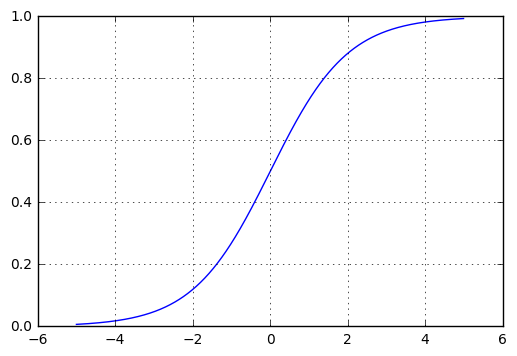

In [2]:
sig = lambda x: 1./(1+np.exp(-x))
X = np.arange(-5,5,0.01)
plt.plot(X,sig(X))
plt.grid()

As we altready know $\sigma(0) = 0.5$ and $\sigma(t) > 0.5$ for $t > 0$. 

Substituting $G(x,\omega_{MAP})$ (and thus ignoring any uncertainty over the model parameters) for t in the above equation we can observe that the probability that a new point $x^{new}$ belogs to class 1 is 0.5 if $G(x^{new}, \omega_{MAP}) = 0$. Thus we can classify a new point $x^{new}$ as class 1 if 
\begin{equation}
G(x^{new}, \omega_{MAP}) > 0
\end{equation}

The surface of constant value $G(x,\omega_{MAP}) = 0$ determines the seperation between the two classes.

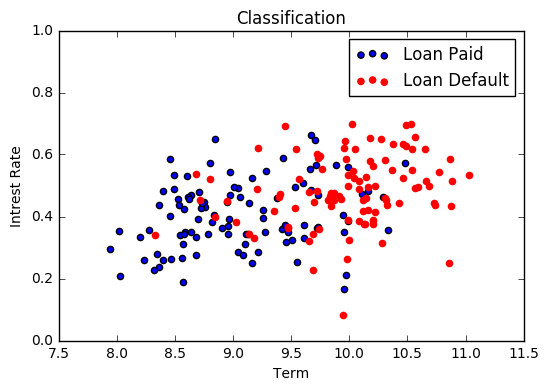

In [3]:
muA = np.array([0.4,9])
covA = np.array([[0.01,0],[0.01,0.3]])
muB = np.array([0.5,10])
covB = np.array([[0.01,0],[0.01,0.3]])
A = np.random.multivariate_normal(muA, covA, size =(100,))
B = np.random.multivariate_normal(muB, covB, size =(100,))
AX = [a[0] for a in A]
AY = [a[1] for a in A]
BX = [a[0] for a in B]
BY = [a[1] for a in B]
fig, ax = plt.subplots(1,1)
ax.scatter(AY,AX, label='Loan Paid')
ax.scatter(BY,BX, color ='red', label ='Loan Default')
ax.set_xlabel('Term')
ax.set_ylabel('Intrest Rate')
ax.set_title('Classification')
ax.set_ylim([0,1])
ax.legend()

**Exercise:**
1. Calculate the MAP solution for the simple linear model $G(x,\omega) = \omega_0 + \omega_1 t + \omega_2 i$
2. Plot the surface of constant value ($G(x,\omega_{MAP})= 0$)
2. Use Cross Validation together with the 0-1 loss (miss-classification loss) to determine the average loss of the model.
3. Write a function that classifies a new point $(t,i)$.
3. Choose a new logistic regression model by choosing a function G that is better suited for the data.(G has to be linear in the model parameters $\omega$. For example: $G(x,\omega) = \omega_0 + \omega_1 t^2 + \omega_2 i^2$
4. Plot the surface of constant value ($G(x,\omega_{MAP})= 0$)
5. Use Cross Validation together with the 0-1 loss (miss-classification loss) to determine the average loss of the new model.
6. Discuss which model is better suited for the situation.

In [4]:
# create list to put into df
dflist = []

#iterate thru data of good loans  and add to df list
for a in A:
    dflist.append([1,a[0],a[1]])

#iterate thru data of bad loans and add to df list
for b in B:
    dflist.append([0,b[0],b[1]])

# convert to dataframe
df = pd.DataFrame(dflist)
# rename columns
df.columns = ['gb','int','term']
df.head()

,gb,int,term
0,1,0.390995,8.963171
1,1,0.547384,9.287006
2,1,0.284555,9.045540
3,1,0.381466,8.820120
4,1,0.340885,8.545288


In [5]:
max_int = df['int'].max()
min_int = df['int'].min()
max_term = df['term'].max()
min_term =  df['term'].min()

def min_max_i(x):
    return (x-min_int)/(max_int-min_int)

def min_max_t(x):
    return (x-min_term)/(max_term-min_term)

df['int'] = df['int'].apply(min_max_i)
df['term'] = df['term'].apply(min_max_t)
df.head()

,gb,int,term
0,1,0.500668,0.330266
1,1,0.753800,0.435079
2,1,0.328385,0.356925
3,1,0.485245,0.283965
4,1,0.419561,0.195013


In [10]:
# linear function
G = lambda w,d: w[0] + w[1]*d[0] + w[2]*d[1]
# sigmoid func
sig = lambda x: 1./(1+np.exp(-x))

# check for 1 or 0 and tke log of p or 1 - p
def atom_log (w,d):
    if d[0] == 1:
        return np.log(sig(G(w,d)))
    else:
        return 1 - np.log(sig(G(w,d)))

atom_log((1,1,1),df.iloc[1,:].values) # .values converts pd into array (which you can iterate over)

#sum of all data + sum of all omegas **2 * .5
# df.values.tolist() turns it to a list
def log_prior (w,b):
    return -.5*b*np.sum([x**2 for x in w])

def log_post (w,b):
    np.sum([atom_log(w)(e) for e in data]) + log_prior(w,b)


